In [1]:
%%capture
! pip install librosa
! pip install torch

In [2]:
import os
import pandas as pd
import s3fs
import zipfile
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from CustomDataset import CustomDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import librosa
from Misc import Misc
from scipy import signal
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F

In [3]:
DATASET_PATH = "../data/LivingRoom_preprocessed_hack"
# Dimensions of the living room
X_MIN = -4000
X_MAX = 500
Y_MIN = -4000
Y_MAX = 2000
MISC = Misc(start_time=0, end_time=50000, sr=44100, target_sr=16000)

## Read Data

In [4]:
centroids_h1 = np.load(DATASET_PATH + "/Human1/centroid.npy")
centroids_h2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_h1 = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
deconvoled_trim_h2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")

In [5]:
print("Deconvoled Trim Human 1 Shape: ", deconvoled_trim_h1.shape)
print("Deconvoled Trim Human 2 Shape: ", deconvoled_trim_h2.shape)
print("Centroids Huma 1 Shape: ", centroids_h1.shape)
print("Centroids Human 2 Shape: ", centroids_h2.shape)

Deconvoled Trim Human 1 Shape:  (1000, 4, 667200)
Deconvoled Trim Human 2 Shape:  (104, 4, 667200)
Centroids Huma 1 Shape:  (1000, 2)
Centroids Human 2 Shape:  (104, 2)


## Normalize Coordinates

In [6]:
def normalize_coordinates(centroids):
    room_width = X_MAX - X_MIN
    room_height = Y_MAX - Y_MIN

    centroids[:, 0] = (centroids[:, 0] - X_MIN) / room_width
    centroids[:, 1] = (centroids[:, 1] - Y_MIN) / room_height
    return centroids

centroids_h1 = normalize_coordinates(centroids_h1)
centroids_h2 = normalize_coordinates(centroids_h2)

## Preprocessing

In [7]:
preprocessed_data_mfcc_h1, preprocessed_data_rms_h1, preprocessed_data_zcr_h1 = MISC.preprocess(deconvoled_trim=deconvoled_trim_h1)
preprocessed_data_mfcc_h2, preprocessed_data_rms_h2, preprocessed_data_zcr_h2 = MISC.preprocess(deconvoled_trim=deconvoled_trim_h2)

100%|██████████| 104/104 [00:02<00:00, 36.53it/s]


## Visualization of the data preprocessed (MFCC)

In [8]:
print("Preprocessed RMS Human 1 data: ", preprocessed_data_rms_h1.shape)
print("Preprocessed Zero-Crossing Rate Human 1 data: ", preprocessed_data_zcr_h1.shape)
print("Preprocessed MFCC Human 1 data: ", preprocessed_data_mfcc_h1.shape)
print("Preprocessed RMS Human 2 data: ", preprocessed_data_rms_h2.shape)
print("Preprocessed Zero-Crossing Rate Human 2 data: ", preprocessed_data_zcr_h2.shape)
print("Preprocessed MFCC Human 2 data: ", preprocessed_data_mfcc_h2.shape)

Preprocessed RMS Human 1 data:  (1000, 4)
Preprocessed Zero-Crossing Rate Human 1 data:  (1000, 4, 1, 36)
Preprocessed MFCC Human 1 data:  (1000, 4, 20, 36)
Preprocessed RMS Human 2 data:  (104, 4)
Preprocessed Zero-Crossing Rate Human 2 data:  (104, 4, 1, 36)
Preprocessed MFCC Human 2 data:  (104, 4, 20, 36)


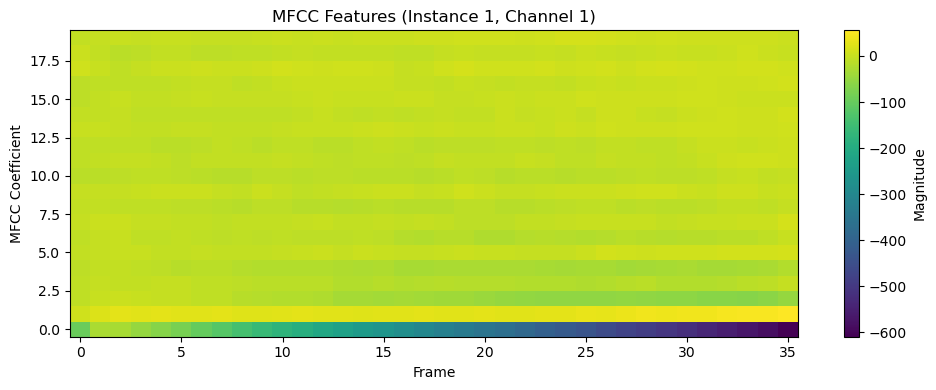

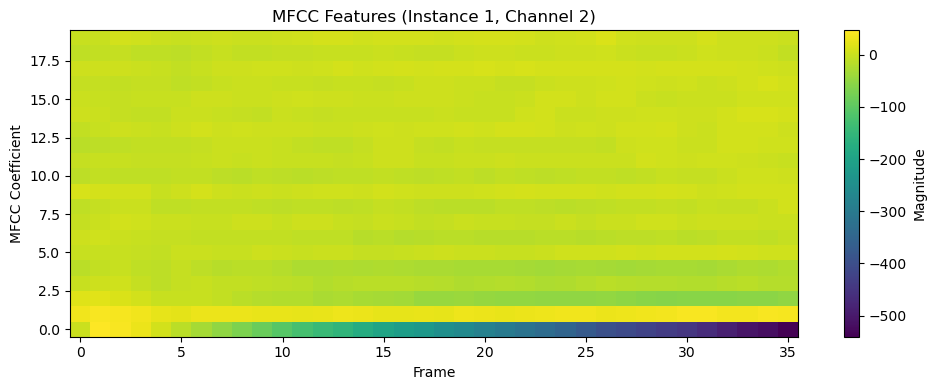

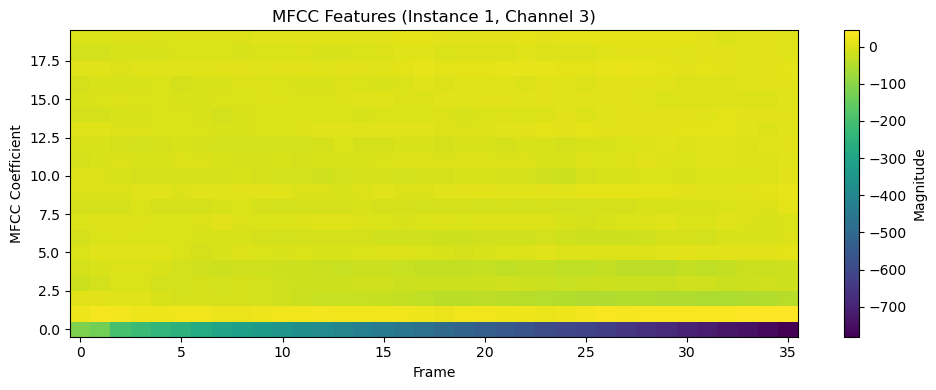

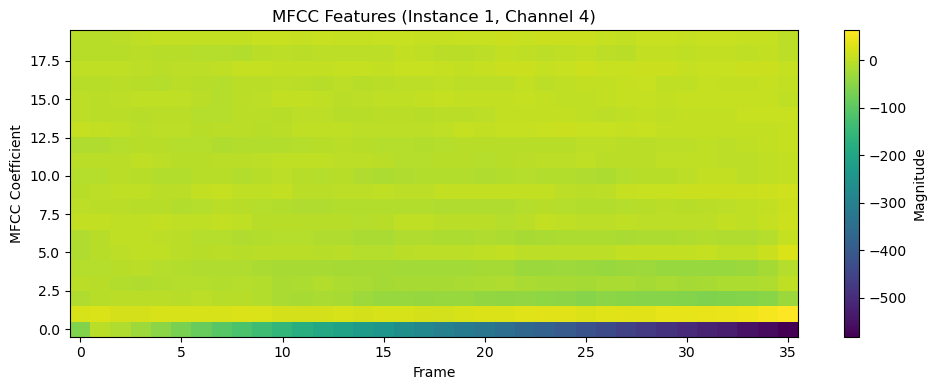

In [9]:
# Plot audio features for 1 instance and 1 channel
instance_index = 0
for channel_index in range(preprocessed_data_mfcc_h2.shape[1]):
    mfcc_features = preprocessed_data_mfcc_h2[instance_index, channel_index]
    MISC.plot_audio_features(instance_index=instance_index, chan_index=channel_index, mfcc=mfcc_features)

## Reduction of 4 Microphones to 1: Summation of MFCC Images

Summed MFCC images for instance 1 in human 2 :


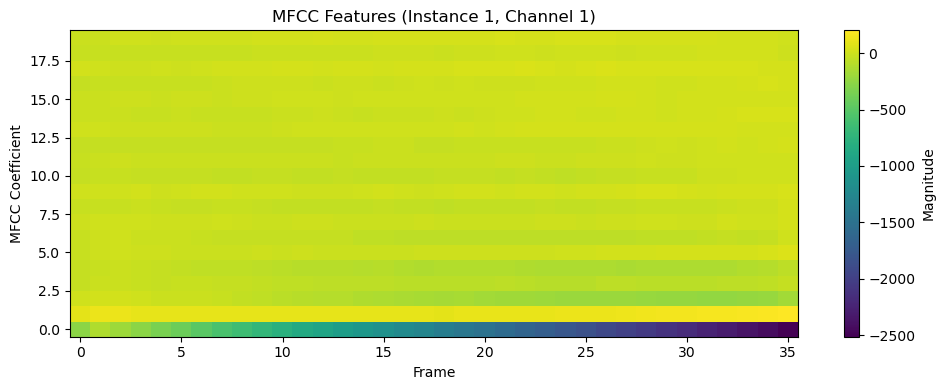

In [10]:
def sum_mfcc_images(data):
    num_instances, num_channels, num_mfcc, feature_size = data.shape
    
    summed_mfcc_images = np.zeros((num_instances, num_mfcc, feature_size))
    
    for instance_index in range(num_instances):
        mfcc_images = data[instance_index]  # Shape: (num_channels, num_mfcc, feature_size)
        summed_mfcc_images[instance_index] = np.sum(mfcc_images, axis=0)
    
    return summed_mfcc_images

summed_mfcc_images_h1 = sum_mfcc_images(preprocessed_data_mfcc_h1)
summed_mfcc_images_h2 = sum_mfcc_images(preprocessed_data_mfcc_h2)

instance_index_to_check = 0
print("Summed MFCC images for instance", instance_index_to_check + 1, "in human 2 :")

mfcc_features_h2 = summed_mfcc_images_h2[instance_index_to_check]
MISC.plot_audio_features(instance_index=instance_index_to_check, chan_index=0, mfcc=mfcc_features_h2)


## Dataset

In [11]:
#dataset_h1 = CustomDataset(preprocessed_data_mfcc=torch.tensor(summed_mfcc_images_h1).unsqueeze(1), _type='mfcc', coordinates=centroids_h1, nb_mics=1)
#dataset_h2 = CustomDataset(preprocessed_data_mfcc=torch.tensor(summed_mfcc_images_h2).unsqueeze(1), _type='mfcc', coordinates=centroids_h2, nb_mics=1)

dataset_h1 = CustomDataset(preprocessed_data_mfcc=preprocessed_data_mfcc_h1, _type='mfcc', coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_mfcc=preprocessed_data_mfcc_h2, _type='mfcc', coordinates=centroids_h2)

# Access a sample from the dataset
features_list, coordinates = dataset_h1[1]
print("Features List Length:", len(features_list))
print("Features Shape (Microphone 1):", features_list[0])
print("Features Shape (Microphone 2):", features_list[1])
print("Features Shape (Microphone 3):", features_list[2])
print("Features Shape (Microphone 4):", features_list[3])
print("Coordinates:", coordinates)

MFCC:  (1000, 4, 20, 36)
MFCC:  (104, 4, 20, 36)
Features List Length: 4
Features Shape (Microphone 1): [[-7.13781967e+01 -9.78182030e+00 -1.56615705e+01 -3.78833961e+01
  -5.20754967e+01 -6.94896545e+01 -9.17617111e+01 -1.09982658e+02
  -1.29474472e+02 -1.46836365e+02 -1.60365509e+02 -1.76945038e+02
  -1.97182922e+02 -2.14535126e+02 -2.33997589e+02 -2.51857071e+02
  -2.68249969e+02 -2.85141541e+02 -3.04045410e+02 -3.20296265e+02
  -3.35668976e+02 -3.53267303e+02 -3.74838837e+02 -3.89813965e+02
  -4.05303375e+02 -4.21745422e+02 -4.42078674e+02 -4.58075012e+02
  -4.73570251e+02 -4.91558502e+02 -5.06641479e+02 -5.21774536e+02
  -5.38877075e+02 -5.55472229e+02 -5.67923218e+02 -5.84632568e+02]
 [ 6.10494423e+00  1.91034164e+01  2.61066227e+01  2.65304337e+01
   2.88824406e+01  2.74174137e+01  2.35202465e+01  2.40294533e+01
   2.24278488e+01  2.20566139e+01  2.42414932e+01  2.64939957e+01
   2.56228676e+01  2.65016136e+01  2.59676895e+01  2.54304771e+01
   2.84643059e+01  2.89779606e+01  2.

In [12]:
batch_size = 32  # Adjust batch size based on your memory constraints and training needs

# Create DataLoader instances for dataset_h1 and dataset_h2
dataloader_h1 = DataLoader(dataset_h1, batch_size=batch_size, shuffle=True)
dataloader_h2 = DataLoader(dataset_h2, batch_size=batch_size, shuffle=False)

# Access a sample from the dataset
features_list, coordinates = dataset_h1[1]
print(dataset_h1[1][0].shape)

(4, 20, 36)


## CNN Model

In [13]:
# Define your custom VGGish-like model
class VGGishMultiChannel(nn.Module):
    def __init__(self, n_channels):
        super(VGGishMultiChannel, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
        self.fc1 = nn.Linear(128 * 5 * 9, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2))
        x = x.view(-1, 128 * 5 * 9)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
def euclidean_distance(pred_coords, true_coords):
    if not isinstance(pred_coords, np.ndarray):
        pred_coords = pred_coords.numpy()
    if not isinstance(true_coords, np.ndarray):
        pred_coords = true_coords.numpy()
    return np.sqrt(np.sum((pred_coords - true_coords)**2))

In [15]:
def euclidean_distance(pred_coords, true_coords):
    """Custom Euclidean distance loss function."""
    return torch.sqrt(torch.sum((pred_coords - true_coords)**2))

class EuclideanDistanceLoss(nn.Module):
    def __init__(self):
        super(EuclideanDistanceLoss, self).__init__()

    def forward(self, pred_coords, true_coords):
        """Compute the Euclidean distance loss."""
        return euclidean_distance(pred_coords, true_coords)

In [16]:
model = VGGishMultiChannel(n_channels=4)

criterion = EuclideanDistanceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # Number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model.to(device)  
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for batch_idx, (features, coordinates) in enumerate(dataloader_h1):
        features = features.to(device)  # Move features to device
        coordinates = coordinates.to(device)  # Move coordinates to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)

        # Compute loss
        loss = criterion(outputs, coordinates)
        print(outputs, coordinates)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if batch_idx % 10 == 9:  # Print every 10 batches
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

print("Training finished!")


tensor([[-1.1909, -0.6605],
        [-1.3136, -0.7080],
        [-1.5142, -0.7127],
        [-1.2038, -0.6001],
        [-0.9180, -0.3535],
        [-1.2532, -0.4573],
        [-1.0447, -0.2236],
        [-1.0789, -0.3956],
        [-0.9870, -0.3738],
        [-1.2090, -0.5882],
        [-1.2625, -0.4750],
        [-1.0467, -0.0892],
        [-0.9568, -0.4525],
        [-1.2472, -0.2749],
        [-1.0389, -0.3429],
        [-1.1705, -0.8869],
        [-1.3318, -0.6020],
        [-1.1745, -0.5025],
        [-1.1581, -0.0711],
        [-1.1023, -0.5224],
        [-1.1811, -0.0607],
        [-1.2292, -0.4725],
        [-1.3830, -0.5421],
        [-1.2569, -0.4963],
        [-1.2445, -0.4066],
        [-0.9877, -0.6871],
        [-1.3744, -0.7401],
        [-1.0658, -0.9074],
        [-0.9853, -0.1538],
        [-1.1487, -0.4495],
        [-1.1616, -0.5338],
        [-1.2576, -0.8497]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[0.2659, 0.1585],
        [0.6554, 0.7220],
        

In [17]:
# Assuming you have a test DataLoader named `test_dataloader`
model.eval()  # Set model to evaluation mode

test_loss = 0.0
num_samples = 0

predicted_coords = []
with torch.no_grad():
    for features, coordinates in dataloader_h2:
        features = features.to(device)
        coordinates = coordinates.to(device)

        # Forward pass
        outputs = model(features)
        predicted_coords.append(outputs)
        # Compute loss (if needed)
        loss = criterion(outputs, coordinates)
        test_loss += loss.item() * features.size(0)  # Accumulate loss

        num_samples += features.size(0)  # Accumulate number of samples

# Calculate average loss
average_test_loss = test_loss / num_samples
# Concatenate all predicted tensors along the batch dimension
predicted_coords_tensor = torch.cat(predicted_coords, dim=0)

# Convert the concatenated tensor to a numpy array
predicted_coords_np = predicted_coords_tensor.cpu().numpy()
print(f"Average Test Loss: {average_test_loss:.4f}")

Average Test Loss: 1.2378


In [18]:
model.eval()  # Set model to evaluation mode

true_coordinates = []
predicted_coordinates = []

with torch.no_grad():
    for features, coordinates in dataloader_h2:
        features = features.to(device)
        coordinates = coordinates.to(device)

        # Forward pass
        outputs = model(features)

        # Collect true and predicted coordinates
        true_coordinates.extend(coordinates.cpu().numpy())  # Assuming coordinates are in numpy arrays
        predicted_coordinates.extend(outputs.cpu().numpy())  # Assuming outputs are in numpy arrays


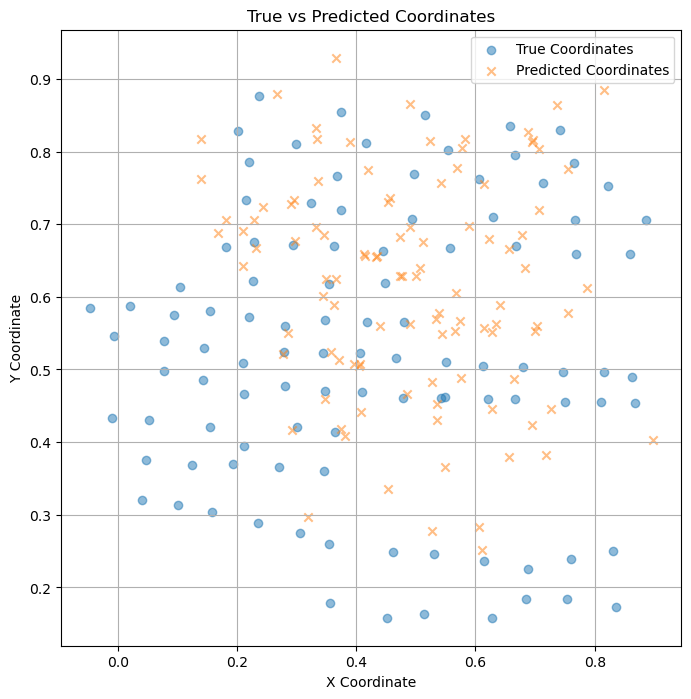

In [19]:
# Convert lists to numpy arrays
true_coordinates = np.array(true_coordinates)
predicted_coordinates = np.array(predicted_coordinates)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(true_coordinates[:, 0], true_coordinates[:, 1], label='True Coordinates', marker='o', alpha=0.5)
plt.scatter(predicted_coordinates[:, 0], predicted_coordinates[:, 1], label='Predicted Coordinates', marker='x', alpha=0.5)
plt.title('True vs Predicted Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

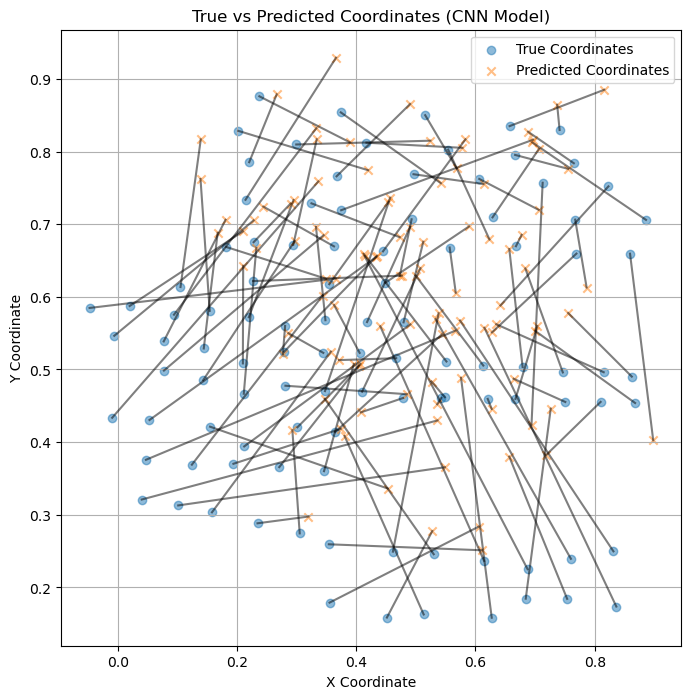

In [21]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming true_coordinates and predicted_coordinates are lists of numpy arrays
true_coordinates = np.array(true_coordinates)
predicted_coordinates = np.array(predicted_coordinates)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(true_coordinates[:, 0], true_coordinates[:, 1], label='True Coordinates', marker='o', alpha=0.5)
plt.scatter(predicted_coordinates[:, 0], predicted_coordinates[:, 1], label='Predicted Coordinates', marker='x', alpha=0.5)

# Draw lines connecting true and predicted coordinates
for true_coord, pred_coord in zip(true_coordinates, predicted_coordinates):
    plt.plot([true_coord[0], pred_coord[0]], [true_coord[1], pred_coord[1]], 'k-', alpha=0.5)  # Plotting the line

plt.title('True vs Predicted Coordinates (CNN Model)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()